In [ ]:
!pip install transformers # I use this to load the pretrained BERT
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
import re
import string
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import files
files.upload()
!pip install transformers

Saving train.csv to train.csv
     |████████████████████████████████| 573kB 2.8MB/s 
     |████████████████████████████████| 1.0MB 8.9MB/s 
     |████████████████████████████████| 3.7MB 18.4MB/s 
     |████████████████████████████████| 890kB 39.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=9328914007eb9510ea8693635ce6d34609bc4235966a5e82b89aa3926367c32c
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [ ]:
kaggle_train  = pd.read_csv('train.csv')

In [ ]:
# Tweets about disasters
kaggle_train[kaggle_train['target']==1]['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 3271, dtype: object

In [ ]:
# Tweets not about disasters
kaggle_train[kaggle_train['target']==0]['text']

15                                         What's up man?
16                                          I love fruits
17                                       Summer is lovely
18                                      My car is so fast
19                           What a goooooooaaaaaal!!!!!!
                              ...                        
7581    @engineshed Great atmosphere at the British Li...
7582    Cramer: Iger's 3 words that wrecked Disney's s...
7584    These boxes are ready to explode! Exploding Ki...
7587                                   Sirens everywhere!
7593    I just heard a really loud bang and everyone i...
Name: text, Length: 4342, dtype: object

Real Percentage: 0.4296597924602653 and Fake Percentage: 0.5703402075397347


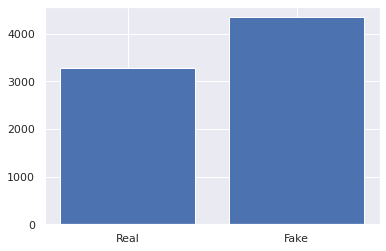

In [ ]:
sns.set()
real_disasters = len(kaggle_train[kaggle_train['target']==1])
fake_disasters = len(kaggle_train[kaggle_train['target']==0])
all_tweets =  len(kaggle_train)
plt.bar(["Real", "Fake"], [real_disasters, fake_disasters])
print(f"Real Percentage: {real_disasters/all_tweets} and Fake Percentage: {fake_disasters/all_tweets}")

# Cleaning the Data
- Remove emojis from every text
- Remove all punctuations
- Make all text lower case
- Remove all stopwords
- Change the format to more formal format (e.g. “what’s” will be “what is”)
- Remove all symbols that are not alphabetical (e.g. “+”, “-”, “=”...etc)
- Remove infrequent words (words that show up less than two times).


In [ ]:
def clean_text(text):
    
    # Remove Emojis
    emoji_pattern = re.compile("["
                          u"\U0001F600-\U0001F64F"  # emoticons
                          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                          u"\U0001F680-\U0001F6FF"  # transport & map symbols
                          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          u"\U00002702-\U000027B0"
                          u"\U000024C2-\U0001F251"
                          "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)

    return text

In [ ]:
# data after cleaning:

kaggle_train['text'] = kaggle_train['text'].map(lambda x: clean_text(x))
kaggle_train['text']

0                  deed reason earthquak may allah forgiv
1                       forest fire near rong sask canada
2       resid ask helter place notifi offic evacu shel...
3         000 peopl receiv wildfir evacu order california
4       got sent photo rubi alaska smoke wildfir pour ...
                              ...                        
7608    two giant crane hold bridg collap nearbi home ...
7609    aria ahrari thetawniest control wild fire cali...
7610             utc 5000m volcano hawaii http zdtoyd8ebj
7611    polic investig bike collid car littl portug bi...
7612    latest home raze northern california wildfir a...
Name: text, Length: 7613, dtype: object

# Starting with a baseline model (Logistic Regression)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(kaggle_train['text'], kaggle_train['target'], test_size=0.2, random_state=1)

In [ ]:
# I'm going to use cross validation to get unbiased performance of the model on the training data

count_vectorizer = feature_extraction.text.CountVectorizer() # Using the common bag of words technique
train_vectors = count_vectorizer.fit_transform(x_train)
baseline_model =  linear_model.LogisticRegression()
f1_scores = model_selection.cross_val_score(baseline_model, train_vectors, y_train, cv=3, scoring="f1")
accuracy_scores = model_selection.cross_val_score(baseline_model, train_vectors, y_train, cv=3, scoring="accuracy")
print(f"Cross Validation Accuracy Scores:", accuracy_scores)
print(f"Cross Validation Accuracy f1_score:", f1_scores)


Cross Validation Accuracy Scores: [0.78817734 0.78817734 0.79458128]
Cross Validation Accuracy f1_score: [0.7319202  0.74002418 0.74526573]


In [ ]:
baseline_model.fit(train_vectors, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Getting the scores on the test:

test_vectors = count_vectorizer.transform(x_test)
baseline_predict_test = baseline_model.predict(test_vectors)
print("Accuracy:", accuracy_score(baseline_predict_test, y_test))
print("F1_score:", f1_score(baseline_predict_test, y_test))

Accuracy: 0.8049901510177282
F1_score: 0.7510477787091367


# BERT and SVC

In [ ]:
# Importing a pretrained BERT model so that I can use it to extract richer features of my dataset:

model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 
                                                    'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
# Tokenizing the data
tokenized = kaggle_train['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
# The BERT model works only when all vectors have the same length. But because some tweets are longer than others, I have to making all 
#vectors the same length by adding zeroes to vectors with shorter lengths (this shouldn't affect the feautres of the sentence)


max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values]) #padding with zeroes
padded.shape

(7613, 49)

In [ ]:
# These are the masks that hide 15% of the words as I explained in my report
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(7613, 49)

In [ ]:
# Now, I pass the data to the model to extract the richer features (I will technically take the output of the last layer):

input_ids = torch.tensor(padded) #.to(torch.int64)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
#As I explained in the report, I only take the CLS(its index is 0) vector because it represents the entire sentence

features = last_hidden_states[0][:,0,:].numpy() 
labels = kaggle_train['target']

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [ ]:
# Now, I will use a support vector classifier to classify the features that I obtained from the pre-trained BERT model

bert_svc = SVC() 

In [ ]:
bert_svc.fit(train_features, train_labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# will check the performance of the model on the test:

bert_svc_test_predict = bert_svc.predict(test_features)

In [ ]:
print("BERT+SVC Accuracy Score:", accuracy_score(bert_svc_test_predict, test_labels))
print("BERT +SVC F1 Score:", f1_score(bert_svc_test_predict, test_labels))

BERT+SVC Accuracy Score: 0.7815126050420168
BERT +SVC F1 Score: 0.7177747625508818


# Fine tuning the paramters of BERT
This is the first time I learn about BERT so I'm going to use some of the codes that I found online in order to be able to fine tune the paramters of the model. All sources are referenced in my report

In [ ]:
# I will use the tokenization script provided by google:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
import tokenization

In [ ]:
def text_encoder(texts, tokenizer, max_len=512):
  # this function will take the text and the tokenizer provided by google and will turn them into the three input types: tokens(words), masks(15% of the words), 
                                                                                                                                            # segments(pairs of sentences)
    all_tokens = [] # bag of words
    all_masks = [] # masks which are words that will be hidden and the model have to predict as part of the training
    all_segments = [] #pairs of sentences that will help the model in learning the sequence
    
    for text in texts:
        text = tokenizer.tokenize(text) # Turning the text into tokens
            
        text = text[:max_len-2] # making sure that all sentences have the same length
        input_sequence = ["[CLS]"] + text + ["[SEP]"] # adding the "CLS":classification and "SEP":sentence separation
                                                      # This tells the model when sentence start and end. This will be the segment input that will train the model
                                                      #on the sequence

        pad_len = max_len - len(input_sequence) # Bert takes as input a padded array
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) #turning the each word into its corresponding ID in the Bert model

        # For Bert to work, all tokens vectors should have the same length, so here I'm adding 0s to vectors with smaller length to ensure
        # that all have the same length. Adding 0 doesn't affect the features because 0 is not an ID for any word in the BERT model
        tokens += [0] * pad_len #
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512): 
    # The Bert model is not mainly designed for classification, so I will add one layer to do classification

    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids") #the tokens
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask") # the masks (hidden words)
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids") # the pairs of sentences

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids]) #extracting the features
    clf_output = sequence_output[:, 0, :] # the BERT model by default returns a vector that represents each word besides one vector that represents all the sentence 
                                          # This is the vector that has the same index (0) as the "CLS" that I inputed above so I'm building classification with that vector
                                          # and I will ignore the other vectors as they are used for other purposes

    out = Dense(1, activation='sigmoid')(clf_output) # Since I have only two classes, I'm adding one layer with a sigmoid function to do the classification
    
    # Adding everything together:
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out) 
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    # I'm using the same paramters used in the origional paper: Adam's optimizer and binary crossentropy which will work on maximizing the likelihood 
    
    return model

In [ ]:
#%%time

# loading the pretrained model:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1'.
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1: 1.23GB
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1, Total size: 1.26GB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1'.


In [ ]:
# splitting the data to evaluate the model
x_train, x_test, y_train, y_test = train_test_split(kaggle_train['text'], kaggle_train['target'], test_size=0.2, random_state=1)

In [ ]:
#processing the data using the functions above

train_input = text_encoder(x_train, tokenizer, max_len=160)
test_input = text_encoder(x_test, tokenizer, max_len=160)
train_labels = y_train

In [ ]:
#finally training the model

model = build_model(bert_layer, max_len=160)
model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    batch_size=16)

Epoch 1/3
305/305 [==============================] - 300s 982ms/step - loss: 0.4902 - accuracy: 0.7621 - val_loss: 0.4274 - val_accuracy: 0.8120
Epoch 2/3
305/305 [==============================] - 297s 975ms/step - loss: 0.3358 - accuracy: 0.8610 - val_loss: 0.4428 - val_accuracy: 0.8071
Epoch 3/3
305/305 [==============================] - 297s 974ms/step - loss: 0.2416 - accuracy: 0.9074 - val_loss: 0.4496 - val_accuracy: 0.8251


In [ ]:
y = model.predict(test_input)

In [ ]:
print("Accuracy score of fine tuned BERT:", accuracy_score(y.round().astype(int), y_test)) # here I'm rounding because sigmoid returns number between 0 and 1
print("F1 score of fine tuned BERT:", f1_score(y.round().astype(int), y_test))              # so im using a treshhold of .5

Accuracy score of fine tuned BERT: 0.8220617202889035
F1 score of fine tuned BERT: 0.7805668016194331


In [ ]:
submission  =pd.read_csv("sample_submission.csv")

In [ ]:
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission_sample.csv')
test_input = text_encoder(test['text'], tokenizer, max_len=160)


test_pred = model.predict(test_input).round().astype(int)

submission['target'] = test_pred.round().astype(int)
submission.to_csv('submission1.csv', index=False)

In [ ]:
files.download('submission1.csv')